In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import tensorflow
tensorflow.__version__

'2.2.0'

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
# tabb seperated values
header_list = ["comments", "sentiment"]
data = pd.read_csv('/tf/deep_learning/sentiment_analysis/data/yelp_labelled.txt', sep='\t', names=header_list)
# print(data)
data["sentiment"]

0      1
1      0
2      0
3      1
4      1
      ..
995    0
996    0
997    0
998    0
999    0
Name: sentiment, Length: 1000, dtype: int64

In [5]:
# split the data into training and test
 X_train, X_test, y_train, y_test = train_test_split(data["comments"], data["sentiment"], test_size=0.20, random_state=42)


In [6]:
print(X_test)

521                     If you haven't gone here GO NOW!
737    Try them in the airport to experience some tas...
740    The restaurant is very clean and has a family ...
660    I personally love the hummus, pita, baklava, f...
411                Come hungry, leave happy and stuffed!
                             ...                        
408                               Service was fantastic.
332    We had fantastic service, and were pleased by ...
208           Must have been an off night at this place.
613    Sorry, I will not be getting food from here an...
78     Today is the second time I've been to their lu...
Name: comments, Length: 200, dtype: object


In [7]:
vocab_size = 10000
max_review_length = 100
oov_tok = "<OOV>"
embedding_dim = 16
#------------------------------- on train data ---------------------------------------------------------#
# tokenize and pading X_train
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
# print(word_index)
## check actual vocab size?
# convert all sentenses to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
# print(sequences)
# padding
train_padding = pad_sequences(train_sequences, truncating='post', padding='post', maxlen=max_review_length)
#------------------------------------- on test data ---------------------------------------------------#
# question - why did we do the tokenizer for test?
# tokenizer.fit_on_texts(X_test)
# word_index = tokenizer.word_index
# print(word_index)
# ## check actual vocab size?
# # convert all sentenses to sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
# print(test_sequences)
# # padding
test_padding = pad_sequences(test_sequences, truncating='post', padding='post', maxlen=max_review_length)

In [8]:
print(train_padding.shape)
print(test_padding.shape)

(800, 100)
(200, 100)


In [9]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(train_padding)
training_labels = np.array(y_train)
testing_padded = np.array(test_padding)
testing_labels = np.array(y_test)

In [14]:
# creating model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_review_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [16]:
num_epochs = 40
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/40
25/25 - 0s - loss: 0.6934 - accuracy: 0.4950 - val_loss: 0.6923 - val_accuracy: 0.5200
Epoch 2/40
25/25 - 0s - loss: 0.6923 - accuracy: 0.5238 - val_loss: 0.6919 - val_accuracy: 0.5650
Epoch 3/40
25/25 - 0s - loss: 0.6912 - accuracy: 0.6737 - val_loss: 0.6917 - val_accuracy: 0.6950
Epoch 4/40
25/25 - 0s - loss: 0.6899 - accuracy: 0.7325 - val_loss: 0.6907 - val_accuracy: 0.6550
Epoch 5/40
25/25 - 0s - loss: 0.6882 - accuracy: 0.7013 - val_loss: 0.6893 - val_accuracy: 0.6300
Epoch 6/40
25/25 - 0s - loss: 0.6864 - accuracy: 0.5462 - val_loss: 0.6873 - val_accuracy: 0.5950
Epoch 7/40
25/25 - 0s - loss: 0.6818 - accuracy: 0.8213 - val_loss: 0.6855 - val_accuracy: 0.7150
Epoch 8/40
25/25 - 0s - loss: 0.6758 - accuracy: 0.7950 - val_loss: 0.6810 - val_accuracy: 0.5900
Epoch 9/40
25/25 - 0s - loss: 0.6690 - accuracy: 0.6425 - val_loss: 0.6769 - val_accuracy: 0.6600
Epoch 10/40
25/25 - 0s - loss: 0.6585 - accuracy: 0.8225 - val_loss: 0.6697 - val_accuracy: 0.6250
Epoch 11/40
25/25 -

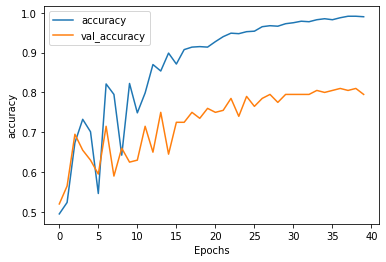

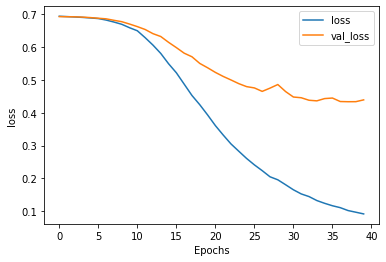

In [17]:
# plot the graph
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
# validating the model
validating = ["I love the food",
             "It is so boring restaurant with really bad food",
              "It is so boring restaurant"]
validate_seq = tokenizer.texts_to_sequences(validating)
validate_padding = pad_sequences(validate_seq, truncating='post', padding='post', maxlen=max_review_length)
print(model.predict(validate_padding))

[[0.90052295]
 [0.35077456]
 [0.71198386]]


In [19]:
# real yelp reviews
validating = ["This is my go to place for a great sized Banh Mi sandwich! The people here are genuinely wonderful hearted individuals that care about what you want! There are a lot of Banh Mi sandwich stores in San Francisco but this one stands out from the rest! I have had the lemon grass chicken sandwich full of chicken and tons of veggies! 5/13 went here again today and it was wonderful again!",
             "To be honest, this isn't particularly amazing, and is actually kind of expensive for a banh mi. There are better places that taste amazing and are $2-$3 cheaper, but they're not in walking distance so."]
validate_seq = tokenizer.texts_to_sequences(validating)
validate_padding = pad_sequences(validate_seq, truncating='post', padding='post', maxlen=max_review_length)
print(model.predict(validate_padding))

[[0.99895597]
 [0.32567722]]


In [20]:
# netflix review on Stranger Things
validating = ["I can't go into great detail because spoiling even just a bit of the story takes away from the greater mystery, but I can say, it's one of the most thrilling and intense series to be on TV, without being on TV. If it were to continue, they have to pull the same punches they did with the first season, because they took a great many clichés, and somehow made them fresh and surprising, save for just a couple that they purposefully left cliché."]
validate_seq = tokenizer.texts_to_sequences(validating)
validate_padding = pad_sequences(validate_seq, truncating='post', padding='post', maxlen=max_review_length)
print(model.predict(validate_padding))

[[0.98517066]]


In [21]:
# RNN - LSTM
# creating model
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_review_length,
                    mask_zero = True, name = 'embadding_layer'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, input_shape=(max_review_length, embedding_dim), return_sequences=False,
               unroll=True, name = 'LSTM_layer')),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [22]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embadding_layer (Embedding)  (None, 100, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               41472     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 209,793
Trainable params: 209,793
Non-trainable params: 0
_________________________________________________________________


In [23]:
num_epochs = 10
lstm_history = lstm_model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
25/25 - 8s - loss: 0.6913 - accuracy: 0.5400 - val_loss: 0.6868 - val_accuracy: 0.6250
Epoch 2/10
25/25 - 3s - loss: 0.6226 - accuracy: 0.7763 - val_loss: 0.5526 - val_accuracy: 0.6850
Epoch 3/10
25/25 - 3s - loss: 0.3610 - accuracy: 0.8888 - val_loss: 0.5888 - val_accuracy: 0.7550
Epoch 4/10
25/25 - 3s - loss: 0.1589 - accuracy: 0.9600 - val_loss: 0.6727 - val_accuracy: 0.7550
Epoch 5/10
25/25 - 3s - loss: 0.0966 - accuracy: 0.9825 - val_loss: 0.6546 - val_accuracy: 0.7800
Epoch 6/10
25/25 - 3s - loss: 0.0558 - accuracy: 0.9912 - val_loss: 0.7966 - val_accuracy: 0.7950
Epoch 7/10
25/25 - 3s - loss: 0.0620 - accuracy: 0.9925 - val_loss: 0.8907 - val_accuracy: 0.8050
Epoch 8/10
25/25 - 3s - loss: 0.0436 - accuracy: 0.9887 - val_loss: 0.9225 - val_accuracy: 0.7650
Epoch 9/10
25/25 - 3s - loss: 0.0242 - accuracy: 0.9962 - val_loss: 1.1418 - val_accuracy: 0.7800
Epoch 10/10
25/25 - 3s - loss: 0.0125 - accuracy: 0.9987 - val_loss: 1.1776 - val_accuracy: 0.7850


In [24]:
# real yelp reviews
validating = ["This is my go to place for a great sized Banh Mi sandwich! The people here are genuinely wonderful hearted individuals that care about what you want! There are a lot of Banh Mi sandwich stores in San Francisco but this one stands out from the rest! I have had the lemon grass chicken sandwich full of chicken and tons of veggies! 5/13 went here again today and it was wonderful again!",
             "To be honest, this isn't particularly amazing, and is actually kind of expensive for a banh mi. There are better places that taste amazing and are $2-$3 cheaper, but they're not in walking distance so."]
validate_seq = tokenizer.texts_to_sequences(validating)
validate_padding = pad_sequences(validate_seq, truncating='post', padding='post', maxlen=max_review_length)
print(lstm_model.predict(validate_padding))

[[1.      ]
 [0.908424]]
